In [202]:
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.float_format",lambda x :"%4f"%x)

In [203]:
df_=pd.read_excel("english_data.xlsx",sheet_name="Year 2009-2010")

In [204]:
df=df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100000,13085.000000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom


In [205]:
def outliers_tresholds(df,var):    
    quantile1=df[var].quantile(0.01)
    quantile3=df[var].quantile(0.99)
    iqr=quantile3-quantile1
    up_limit=quantile3+1.5*iqr
    low_limit=quantile1-1.5*iqr
    return up_limit,low_limit

In [206]:
def replace_with_tresholds(df,var):    
    up_limit,low_limit=outliers_tresholds(df,var)
    #df[var]=[low_limit for i in df[var] if i<low_limit]
    df[var]=[up_limit if i>up_limit else i for i in df.loc[:,var] ]
    
    

In [207]:
#veri ön işleme
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [208]:
df.dropna(inplace=True)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100000,13085.000000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.950000,17530.000000,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom


In [209]:
#Başında C olanlar iade işlemi olduğu için eksi değerler oluşturuyor onları veriden çıkarıyoruz
 
df=df[~( df["Invoice"].str.contains("C",na=False))]
df=df[df["Quantity"] > 0]
df=df[df["Price"] > 0]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100000,13085.000000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.950000,17530.000000,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom


In [210]:
replace_with_tresholds(df,"Quantity")
replace_with_tresholds(df,"Price")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.000000,11.906525,28.725110,1.000000,2.000000,5.000000,12.000000,358.500000
Price,407664.000000,3.005620,3.250568,0.001000,1.250000,1.950000,3.750000,36.940000
Customer ID,407664.000000,15368.592598,1679.762138,12346.000000,13997.000000,15321.000000,16812.000000,18287.000000


In [211]:
df["total_price"]=df["Price"] * df["Quantity"]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.000000,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom,83.400000
1,489434,79323P,PINK CHERRY LIGHTS,12.000000,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom,81.000000
2,489434,79323W,WHITE CHERRY LIGHTS,12.000000,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom,81.000000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.000000,2009-12-01 07:45:00,2.100000,13085.000000,United Kingdom,100.800000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.000000,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom,30.000000
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2.000000,2010-12-09 20:01:00,2.950000,17530.000000,United Kingdom,5.900000
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1.000000,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom,3.750000
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1.000000,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom,3.750000
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2.000000,2010-12-09 20:01:00,3.750000,17530.000000,United Kingdom,7.500000


In [212]:
today_date=dt.datetime(2011,12,11)

In [213]:
cltv_df=df.groupby("Customer ID").agg({"InvoiceDate":[lambda InvoiceDate : (InvoiceDate.max() - InvoiceDate.min()).days,
                                                     lambda date : (today_date - date.min()).days ],
                                      "Invoice" : lambda Invoice: Invoice.nunique(),
                                      "total_price" :lambda total_price: total_price.sum()})
cltv_df

InvoiceDate             Invoice total_price
              <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                             
12346.000000         196        726       11  372.860000
12347.000000          37        405        2 1323.320000
12348.000000           0        439        1  222.160000
12349.000000         181        590        3 2295.020000
12351.000000           0        376        1  300.930000
...                  ...        ...      ...         ...
18283.000000         275        659        6  641.770000
18284.000000           0        432        1  448.620000
18285.000000           0        661        1  413.940000
18286.000000         247        724        2 1283.370000
18287.000000         188        572        4 2332.650000

[4312 rows x 4 columns]

In [214]:
cltv_df.columns=cltv_df.columns.droplevel(0)
cltv_df.columns=["recency","T","frequency","monetary"]
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.000000,196,726,11,372.860000
12347.000000,37,405,2,1323.320000
12348.000000,0,439,1,222.160000
12349.000000,181,590,3,2295.020000
12351.000000,0,376,1,300.930000
...,...,...,...,...
18283.000000,275,659,6,641.770000
18284.000000,0,432,1,448.620000
18285.000000,0,661,1,413.940000


In [215]:
cltv_df["monetary"]=cltv_df["monetary"] / cltv_df["frequency"]
cltv_df=cltv_df[cltv_df["frequency"] >1]
cltv_df["recency"]=cltv_df["recency"] /7
cltv_df["T"]=cltv_df["T"] /7
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.000000,28.000000,103.714286,11,33.896364
12347.000000,5.285714,57.857143,2,661.660000
12349.000000,25.857143,84.285714,3,765.006667
12352.000000,2.285714,56.142857,2,171.900000
12356.000000,6.285714,60.714286,3,1187.416667
...,...,...,...,...
18276.000000,48.000000,104.285714,5,264.132000
18277.000000,13.857143,70.714286,4,256.665000
18283.000000,39.285714,94.142857,6,106.961667


In [216]:
bgf=BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.93, alpha: 9.47, b: 6.27, r: 2.22>

In [217]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"]).sort_values(ascending=False)

Customer ID
15989.000000   0.007560
16720.000000   0.007216
14119.000000   0.007197
16204.000000   0.007153
17591.000000   0.007135
                 ...   
13089.000000   0.000000
15311.000000   0.000000
12748.000000   0.000000
17850.000000   0.000000
14911.000000   0.000000
Length: 2893, dtype: float64

AttributeError: module 'matplotlib' has no attribute 'show'

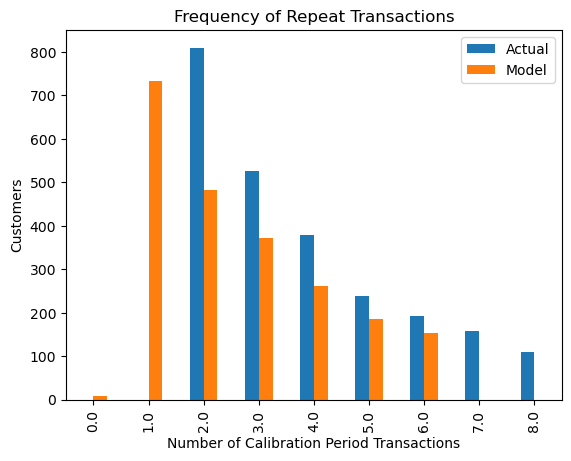

In [218]:
plot_period_transactions(bgf)
plt.show()

In [219]:
ggf=GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 12.23, q: 0.93, v: 12.14>

In [220]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"]).sort_values(ascending=False)

Customer ID
12357.000000   5655.631832
17450.000000   5327.651644
14091.000000   4603.216183
14088.000000   4525.623546
18102.000000   3526.804376
                   ...    
17246.000000     25.601228
15359.000000     24.203062
14610.000000     18.295433
16454.000000     18.145005
18037.000000     12.178449
Length: 2893, dtype: float64

In [221]:
cltv=ggf.customer_lifetime_value(bgf,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"],cltv_df["monetary"],time=3,freq="W",discount_rate=0.01)

In [236]:
cltv=cltv.reset_index()

In [237]:
cltv["segment"]=pd.qcut(cltv["clv"],4,labels=["d","c","b","a"])
cltv

,index,Customer ID,clv,segment
0,0,12346.000000,0.000182,d
1,1,12347.000000,3.017657,b
2,2,12349.000000,13.021110,a
3,3,12352.000000,0.352905,c
4,4,12356.000000,1.805128,b
...,...,...,...,...
2888,2888,18276.000000,7.484866,a
2889,2889,18277.000000,0.520664,c
2890,2890,18283.000000,1.201881,c
2891,2891,18286.000000,20.662246,a
